# Aeroelastic Analysis of the Goland Wing

In this example, we demonstrate how to perform a three-dimensional aeroelastic analysis
using the Goland wing, a low-aspect ratio prismatic metallic wing, which has been
extensively used for validation.

![](../assets/goland-wing.png)

The Goland wing is a cantilevered wing with a 20 ft span and 6 ft chord.  Its airfoil
consists of a 4% thick parabolic arc.  There are two configurations for this wing, one
with a tip store and one without.  The configuration we consider in this example is
the configuration without a tip store.

The deflections of Goland wing are relatively small, so linear structural models are
sufficient for modeling the wing's structure.  However, to demonstrate the
capabilities of this package, we will use a nonlinear geometrically exact beam
theory model.

For the aerodynamics, we use a lifting line model which is capable of using a
variety of 2D models to model section lift and moment coefficients.  This aerodynamic
model is ill-suited for modeling this wing due to the wing's low aspect ratio.  As
a result, we cannot expect our results to accurately model the wing's physical behavior,
however, we can expect them to be similar to the results found by similar analyses.

In [1]:
using Aeroelasticity, GXBeam, DifferentialEquations, LinearAlgebra

# --- Initial Setup --- #

# discretization
N = 8 # number of elements

# geometric properties
span = 6.096 # m (20 ft span)
chord = 1.8288 # m (6 ft chord)

# structural section properties
xea = 0.33*chord # m (elastic axis, from leading edge)
EIcc = 9.77e6 # N*m^2 (flat bending rigidity)
GJ = 0.99e6 # N*m^2 (torsional rigidity)
mu = 35.71 # kg/m (mass per unit length)
xcm = 0.43*chord # m (center of mass, from leading edge)
i11 = 8.64 # kg*m (moment of inertia about elastic axis)
i22 = 0.1*i11 # moment of inertia about beam y-axis
i33 = 0.9*i11 # moment of inertia about beam z-axis

7.776000000000001

freestream properties

In [2]:
Vinf = 100 # m/s (velocity)
rho = 1.02 # kg/m^3 (air density)
c = 343 # m/s (air speed of sound)
alpha = 0 # angle of attack
V = [-Vinf*cos(alpha), 0.0, -Vinf*sin(alpha)] # m/s (velocity)

# aerodynamic section properties
xref = xea/chord # normalized reference location (relative to leading edge)
a = xref - 0.5 # normalized reference location (relative to semi-chord)
b = chord / 2 # m (semi-chord)
a0 = 0.85*(2*pi) # lift slope (for each section)
alpha0 = 0 # zero lift angle of attack (for each section)
cd0 = 0
cm0 = 0

# define geometry (use NED coordinate frame)
xpt = range(0, 0, length=N+1) # point x-coordinates (in body frame)
ypt = range(0, span, length=N+1) # point y-coordinates (in body frame)
zpt = range(0, 0, length=N+1) # point z-coordinates (in body frame)
points = [[xpt[i],ypt[i],zpt[i]] for i = 1:N+1]
start = 1:N # starting point of each beam element
stop = 2:N+1 # ending point of each beam element
e1 = [0, 1,  0] # beam x-axis
e2 = [1, 0,  0] # beam y-axis
e3 = [0, 0, -1] # beam z-axis
frames = fill([e1 e2 e3], N) # local to body frame transformation
compliance = fill(Diagonal([0, 0, 0, 1/GJ, 1/EIcc, 0]), N) # compliance matrix
xm2 = xea - xcm
mass = fill([ # mass matrix
    mu 0 0 0 0 -mu*xm2;
    0 mu 0 0 0 0;
    0 0 mu mu*xm2 0 0;
    0 0 mu*xm2 i11 0 0;
    0 0 0 0 i22 0;
    -mu*xm2 0 0 0 0 i33], N)

# define beam assembly
assembly = GXBeam.Assembly(points, start, stop; frames, compliance, mass)

# define prescribed conditions
prescribed_conditions = Dict(
    # fixed left edge
    1 => GXBeam.PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0),
)

# define GXBeam system
system = DynamicSystem(assembly)

# --- Define Submodels --- #

# define aerodynamic models for each lifting line section
section_models = fill(Peters{6}(), N)

# construct lifting line model using lifting line section models
aerodynamic_model = LiftingLine(section_models)

# construct geometrically exact beam theory model
structural_model = GXBeamAssembly(system; structural_damping=false)

# combine submodels
submodels = (aerodynamic_model, structural_model)

# --- Define Initial Parameters --- #

# define parameters for each lifting line section
section_parameters = fill([a, b, a0, alpha0, cd0, cm0], N)

# define parameters for the lifting line model
liftingline_parameters = LiftingLineParameters(section_parameters)

# define parameters for the geometrically exact beam theory model
gxbeam_parameters = GXBeamParameters(assembly)

GXBeam.Assembly{Float64, Vector{StaticArraysCore.SVector{3, Float64}}, UnitRange{Int64}, Vector{GXBeam.Element{Float64}}}(StaticArraysCore.SVector{3, Float64}[[0.0, 0.0, 0.0], [0.0, 0.762, 0.0], [0.0, 1.524, 0.0], [0.0, 2.286, 0.0], [0.0, 3.048, 0.0], [0.0, 3.81, 0.0], [0.0, 4.572, 0.0], [0.0, 5.334, 0.0], [0.0, 6.096, 0.0]], 1:8, 2:9, GXBeam.Element{Float64}[GXBeam.Element{Float64}(0.762, [0.0, 0.381, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0235414534288639e-7 0.0; 0.0 0.0 … 0.0 0.0], [35.71 0.0 … 0.0 6.5306447999999975; 0.0 35.71 … 0.0 0.0; … ; 0.0 0.0 … 0.8640000000000001 0.0; 6.5306447999999975 0.0 … 0.0 7.776000000000001], [0.0 1.0 0.0; 1.0 0.0 0.0; 0.0 0.0 -1.0], [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]), GXBeam.Element{Float64}(0.762, [0.0, 1.143, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0235414534288639e-7 0.0; 0.0 0.0 … 0.0 0.0], [35.71 0.0 … 0.0 6.5306447999999975; 0.0 35.71 … 0.0 0.0; … ; 0.0 0.0 … 0.8640000000000001 0.0; 6.53064479999999

define parameters for the coupling

In [3]:
coupling_parameters = LiftingLineGXBeamParameters(V, rho, c; prescribed_conditions = prescribed_conditions)

# combine parameters
parameters = (liftingline_parameters, gxbeam_parameters, coupling_parameters)

# --- Define Coupled Model --- #

model = CoupledModel(submodels, parameters; symbolic=false)

# --- Perform Analysis --- #

# loop through freestream velocities
Vinf = vcat(1, 5:5:200)

# eigenvalue/eigenvector storage
nev = 12*N
λ = zeros(ComplexF64, nev, length(Vinf))
Uλ = zeros(ComplexF64, nev, number_of_states(model), length(Vinf))
Vλ = zeros(ComplexF64, number_of_states(model), nev, length(Vinf))

# initial guess for state variables
x0 = zeros(number_of_states(model))

# loop through each velocity
for i = 1:length(Vinf)

    # --- Update Parameters --- #

    V = [-Vinf[i]*cos(alpha), 0.0, -Vinf[i]*sin(alpha)] # m/s (velocity)

    # define parameters for each lifting line section
    section_parameters = fill([a, b, a0, alpha0, cd0, cm0], N)

    # define parameters for the lifting line model
    liftingline_parameters = LiftingLineParameters(section_parameters)

    # define parameters for the geometrically exact beam theory model
    gxbeam_parameters = GXBeamParameters(assembly)

    # define parameters for the coupling
    coupling_parameters = LiftingLineGXBeamParameters(V, rho, c;
        prescribed_conditions = prescribed_conditions)

    # combine parameters
    parameters = (liftingline_parameters, gxbeam_parameters, coupling_parameters)

    # --- Perform Analysis --- #

    # define an ODEFunction for this model
    f = ODEFunction(model, parameters)

    # find equilibrium point
    sol = solve(NonlinearProblem(SteadyStateProblem(f, x0, parameters)))

    # use state variables from steady state operating conditions
    x = sol.u

    # linearize about steady state operating conditions
    K, M = linearize(model, x, parameters)

    # perform linear stability analysis
    λi, Uλi, Vλi = sparse_eigen(K, M; nev=nev)

    # --- Correlate Eigenvalues --- #

    if i > 1
        # previous left eigenvector matrix
        Uλpi = Uλ[:,:,i-1]

        # use correlation matrix to correlate eigenmodes
        perm, corruption = Aeroelasticity.correlate_eigenmodes(Uλpi, M, Vλi)

        # re-arrange eigenmodes
        λi = λi[perm]
        Uλi = Uλi[perm,:]
        Vλi = Vλi[:,perm]
    end

    # save eigenvalues/eigenvectors
    λ[:,i] = λi
    Uλ[:,:,i] = Uλi
    Vλ[:,:,i] = Vλi

    # update initial guess for the state variables
    x0 .= x
end

┌ Warning: Assignment to `V` in soft scope is ambiguous because a global variable by the same name exists: `V` will be treated as a new local. Disambiguate by using `local V` to suppress this warning or `global V` to assign to the existing global variable.
└ @ ~/work/Aeroelasticity.jl/Aeroelasticity.jl/docs/src/examples/goland-stability.ipynb:29
┌ Warning: Assignment to `section_parameters` in soft scope is ambiguous because a global variable by the same name exists: `section_parameters` will be treated as a new local. Disambiguate by using `local section_parameters` to suppress this warning or `global section_parameters` to assign to the existing global variable.
└ @ ~/work/Aeroelasticity.jl/Aeroelasticity.jl/docs/src/examples/goland-stability.ipynb:32
┌ Warning: Assignment to `liftingline_parameters` in soft scope is ambiguous because a global variable by the same name exists: `liftingline_parameters` will be treated as a new local. Disambiguate by using `local liftingline_parameters

To identify the flutter speed and frequency, we can plot the results.

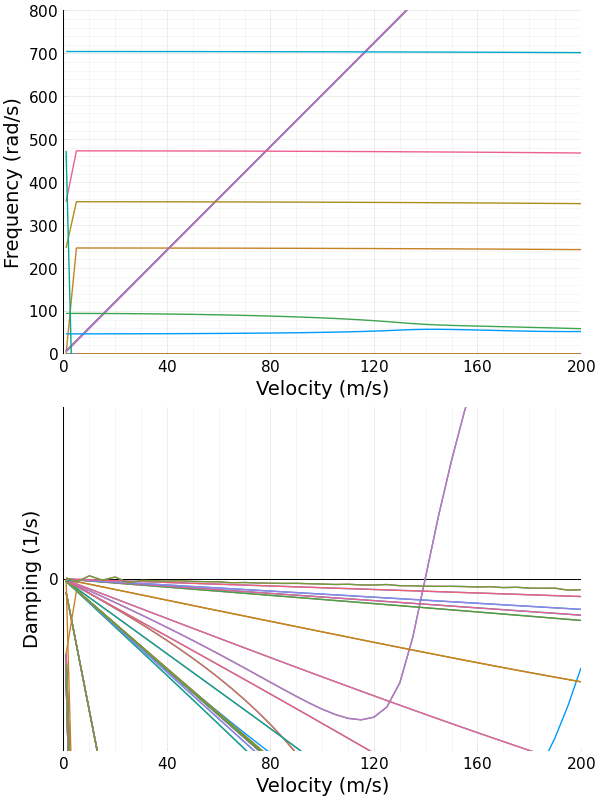

In [4]:
using Plots
pyplot()

sp1 = plot(
    xlim = (0, 200),
    xtick = 0:40:200,
    xlabel = "Velocity (m/s)",
    ylim = (0, 800),
    ytick = 0:100:800,
    ylabel = "Frequency (rad/s)",
    framestyle = :zerolines,
    titlefontsize = 14,
    guidefontsize = 14,
    legendfontsize = 11,
    tickfontsize = 11,
    legend = :topright,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    minorgrid=true)

sp2 = plot(
    xlim = (0, 200),
    xtick = 0:40:200,
    xlabel = "Velocity (m/s)",
    ylim = (-5, 5),
    ytick = -80:20:20,
    ylabel = "Damping (1/s)",
    framestyle = :zerolines,
    titlefontsize = 14,
    guidefontsize = 14,
    legendfontsize = 11,
    tickfontsize = 11,
    legend = :topright,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    minorgrid=true)

for i = 1:size(λ, 1)

    Vi = Vinf[:]
    λi = λ[i,:]

    if any(-80 .<= real.(λi) .<= 20)
        plot!(sp1, Vi, imag.(λi),
            label = "",
            color = i,
            markersize = 3,
            markerstrokewidth = 0,
            )
    end

end

for i = 1:size(λ, 1)

    Vi = Vinf[:]
    λi = λ[i,:]

    if any(-80 .<= real.(λi) .<= 20)
        plot!(sp2, Vi,
            real.(λi),
            label = "",
            color = i,
            markersize = 3,
            markerstrokewidth = 0,
            )
    end
end

p1 = plot(sp1, sp2, layout = (2, 1), size = (600, 800))

As predicted by this analysis, the flutter speed is 140 m/s and the flutter frequency
is 69.0 rad/s.  These results compare well with the results found by Palacios and Epureanu
in "An Intrinsic Description of the Nonlinear Aeroelasticity of Very Flexible Wings".
Their analysis, which was also based on lifting line aerodynamics predicted a flutter
speed of 141 m/s and a flutter frequency of 69.8 rad/s.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*